
# Import packages

In [1]:
import sys
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

sys.path.append('../../')
from utils import dataframe_utils

# Import the data for each timepoint

In [2]:
file_paths = sorted(glob.glob('../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_*'))
file_paths

['../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_000min_A',
 '../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_000min_B',
 '../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_030min_A',
 '../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_030min_B',
 '../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_060min_A',
 '../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_060min_B',
 '../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_090min_A',
 '../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_090min_B',
 '../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_120min_A',
 '../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_120min_B',
 '../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_150min_A',
 '../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_150min_B',
 '../../input_data/kallisto_data_folders/kallisto_quant_p_trimmed_180min_A',

In [3]:
dict_tpms = {}

for fp in file_paths:
    split = ((os.path.splitext(os.path.basename(fp))[0]).split('_'))
    key = '_'.join(split[len(split)-2:len(split)])
    print(key)
    dict_tpms[key] = (pd.read_csv(os.path.join(fp, 'abundance.tsv'), delimiter='\t'))

print(np.unique([df.shape for df in dict_tpms.values()]))

000min_A
000min_B
030min_A
030min_B
060min_A
060min_B
090min_A
090min_B
120min_A
120min_B
150min_A
150min_B
180min_A
180min_B
210min_A
210min_B
240min_A
240min_B
[    5 26687]


In [4]:
dict_tpms['000min_A'].head()

,target_id,length,eff_length,est_counts,tpm
0,TTHERM_00161861,420,234.021,12.0,0.494446
1,TTHERM_00161860,4356,4167.380,11088.0,25.655600
2,TTHERM_00161850,1200,1011.380,102.0,0.972475
3,TTHERM_00161840,498,310.211,907.0,28.193000
4,TTHERM_00161830,1077,888.377,1320.0,14.327400


In [5]:
def computeRPK(row):
    if not row['eff_length'] > 0:
        print('ZERO sequence length:', row['target_id'])
        print(row)
        return 'ZERO sequence length'
    return row['est_counts']/row['eff_length']

def computeTPM(row, normalization_factor):
    return row['rpk']/normalization_factor

def compute_tpm_columns(df_dict):
    df_tpm = {}
    normalization_factor_dict = {}
    for key, df in df_dict.items():
        tpm_df = df
        tpm_df['rpk'] = tpm_df.apply(computeRPK, axis=1)
        tpm_df = tpm_df.loc[tpm_df['rpk']!='ZERO sequence length']

        sum_rpk = tpm_df['rpk'].sum()

        normalization_factor = sum_rpk/1_000_000

        tpm_df['tpm_manual'] = tpm_df.apply(computeTPM, axis=1, args=(normalization_factor,))

        df_tpm[key] = tpm_df  
        normalization_factor_dict[key] = normalization_factor

    return df_tpm, normalization_factor_dict

def compute_cpm_columns(df_dict):
    df_cpm = {}
    for key, df in df_dict.items():
        cpm_df = df

        sum_count = cpm_df['est_counts'].sum()

        cpm_df['cpm_manual'] = (cpm_df['est_counts'] / sum_count) * 1_000_000

        df_cpm[key] = cpm_df  

    return df_cpm

In [6]:
dict_tpms, norm_factors_dict = compute_tpm_columns(dict_tpms)

In [7]:
dict_tpms['150min_A'].head()

,target_id,length,eff_length,est_counts,tpm,rpk,tpm_manual
0,TTHERM_00161861,420,237.091,10.0,0.464797,0.042178,0.464797
1,TTHERM_00161860,4356,4170.270,14919.0,39.423300,3.577466,39.423350
2,TTHERM_00161850,1200,1014.270,1122.0,12.190400,1.106214,12.190380
3,TTHERM_00161840,498,313.435,1276.0,44.862300,4.071020,44.862262
4,TTHERM_00161830,1077,891.270,1585.0,19.597400,1.778361,19.597378


In [8]:
dict_cpms = compute_cpm_columns(dict_tpms)

In [9]:
dict_cpms['150min_A'].head()

,target_id,length,eff_length,est_counts,tpm,rpk,tpm_manual,cpm_manual
0,TTHERM_00161861,420,237.091,10.0,0.464797,0.042178,0.464797,0.202593
1,TTHERM_00161860,4356,4170.270,14919.0,39.423300,3.577466,39.423350,302.248006
2,TTHERM_00161850,1200,1014.270,1122.0,12.190400,1.106214,12.190380,22.730898
3,TTHERM_00161840,498,313.435,1276.0,44.862300,4.071020,44.862262,25.850825
4,TTHERM_00161830,1077,891.270,1585.0,19.597400,1.778361,19.597378,32.110938


In [10]:
norm_factors_dict

{'000min_A': 0.1037070326424425,
 '000min_B': 0.11857840271950969,
 '030min_A': 0.10993092399697786,
 '030min_B': 0.10524329474002664,
 '060min_A': 0.10363163917643455,
 '060min_B': 0.12963020406668638,
 '090min_A': 0.0952828245820684,
 '090min_B': 0.11038255683949492,
 '120min_A': 0.09625930761158062,
 '120min_B': 0.11952187127800394,
 '150min_A': 0.09074485643941699,
 '150min_B': 0.11275799305552293,
 '180min_A': 0.10914940225442674,
 '180min_B': 0.10916250389631336,
 '210min_A': 0.0825653695429961,
 '210min_B': 0.10398363852428015,
 '240min_A': 0.11956682547853985,
 '240min_B': 0.11169527770156734}

In [12]:
dict_tpms['000min_A'].shape

(26687, 8)

## Checkout a single timepoint

In [13]:
num_nonzero = (dict_tpms['000min_A'].loc[dict_tpms['000min_A']['tpm'] != 0.0].shape)[0]

mean = dict_tpms['000min_A']['tpm'].mean()

std = dict_tpms['000min_A']['tpm'].std()

str_summary_wzeros = f'''WITH ZEROS...
MEAN: {mean}
MEDIAN: {dict_tpms['000min_A']['tpm'].median()}
STDEV: {std}
CV: {(std/mean)*100}
MAX: {dict_tpms['000min_A']['tpm'].max()}
MIN: {dict_tpms['000min_A']['tpm'].min()}
# GENES EXPRESSED: {num_nonzero}
'''

df_tpm_wozeros = dict_tpms['000min_A'].loc[dict_tpms['000min_A']['tpm'] != 0.0]

mean_wozeros = df_tpm_wozeros['tpm'].mean()

std_wozeros = df_tpm_wozeros['tpm'].std()

str_summary_wozeros = f'''WITHOUT ZEROS...
MEAN: {mean_wozeros}
MEDIAN: {df_tpm_wozeros['tpm'].median()}
STDEV: {std_wozeros}
CV: {(std_wozeros/mean_wozeros)*100}
MAX: {df_tpm_wozeros['tpm'].max()}
MIN: {df_tpm_wozeros['tpm'].min()}
# GENES EXPRESSED: {num_nonzero}
'''

print(str_summary_wzeros, '\n', str_summary_wozeros, sep='')


WITH ZEROS...
MEAN: 37.47142659130371
MEDIAN: 0.815177
STDEV: 385.9761602256753
CV: 1030.05461851098
MAX: 28942.1
MIN: 0.0
# GENES EXPRESSED: 23539

WITHOUT ZEROS...
MEAN: 42.482686666473604
MEDIAN: 1.23647
STDEV: 410.7178296710274
CV: 966.7887365399533
MAX: 28942.1
MIN: 1.59363e-08
# GENES EXPRESSED: 23539



# Create a dataframe containing all data at every timepoint (sorted by TTHERM_ID)

In [14]:
column_prefixes = sorted(list(dict_tpms.keys()))
column_prefixes

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [15]:
complete_data_df = None

for col_prefix in column_prefixes:
    curr_df = dict_tpms[col_prefix].sort_values(by='target_id')
    curr_df.rename(columns={col: (f'{col_prefix}_{col}') for col in list(curr_df.columns) if col != 'target_id'}, inplace=True)

    if complete_data_df is None:
        complete_data_df = curr_df
        continue

    complete_data_df = dataframe_utils.sql_query_df({'complete_data_df': complete_data_df, 'curr_df': curr_df},
                                                    '''SELECT * FROM complete_data_df
                                                       INNER JOIN curr_df USING(target_id)'''
                                                    )

complete_data_df.rename(columns={'target_id': 'TTHERM_ID'}, inplace=True)
complete_data_df


,TTHERM_ID,000min_A_length,000min_A_eff_length,000min_A_est_counts,000min_A_tpm,000min_A_rpk,000min_A_tpm_manual,000min_A_cpm_manual,000min_B_length,000min_B_eff_length,...,240min_A_rpk,240min_A_tpm_manual,240min_A_cpm_manual,240min_B_length,240min_B_eff_length,240min_B_est_counts,240min_B_tpm,240min_B_rpk,240min_B_tpm_manual,240min_B_cpm_manual
0,TTHERM_00000010,1587,1398.380,347.0000,2.392750,0.248144,2.392743,6.176870,1587,1400.310,...,0.057392,0.480000,1.299130,1587,1397.010,86.0000,0.551144,0.061560,0.551143,1.502907
1,TTHERM_00000020,1665,1476.380,10.0000,0.065312,0.006773,0.065312,0.178008,1665,1478.310,...,0.029893,0.250010,0.714522,1665,1475.010,13.0000,0.078907,0.008813,0.078907,0.227184
2,TTHERM_00000030,1887,1698.380,54.0000,0.306585,0.031795,0.306585,0.961242,1887,1700.310,...,0.002952,0.024687,0.081196,1887,1697.010,2.0000,0.010551,0.001179,0.010551,0.034951
3,TTHERM_00000031,360,176.970,0.0000,0.000000,0.000000,0.000000,0.000000,360,178.737,...,0.000000,0.000000,0.000000,360,175.787,0.0000,0.000000,0.000000,0.000000,0.000000
4,TTHERM_00000040,2958,2769.380,644.0000,2.242310,0.232543,2.242307,11.463702,2958,2771.310,...,0.211941,1.772574,9.516130,2958,2768.010,668.0000,2.160600,0.241329,2.160598,11.673741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26682,TTHERM_02653514,924,735.377,0.0000,0.000000,0.000000,0.000000,0.000000,924,737.306,...,0.000000,0.000000,0.000000,924,734.006,0.0000,0.000000,0.000000,0.000000,0.000000
26683,TTHERM_02653516,897,708.377,77.0157,1.048350,0.108721,1.048351,1.370939,897,710.306,...,0.068218,0.570546,0.779808,897,707.006,51.0228,0.646110,0.072167,0.646110,0.891657
26684,TTHERM_02653518,1443,1254.380,186.3350,1.432380,0.148547,1.432376,3.316908,1443,1256.310,...,0.144849,1.211450,2.940094,1443,1253.010,163.0530,1.165040,0.130129,1.165036,2.849459
26685,TTHERM_06324284,1797,1608.380,285.1850,1.709740,0.177312,1.709739,5.076515,1797,1610.310,...,0.155302,1.298872,4.045037,1797,1607.010,247.1160,1.376730,0.153774,1.376726,4.318515


In [16]:
# 10 reads cuttoff
complete_data_df['max_count'] = complete_data_df[[col for col in complete_data_df if 'counts' in col]].apply(lambda x: max(x), axis=1)

In [17]:
complete_data_df_filtered = complete_data_df.loc[complete_data_df['max_count'] > 10]
complete_data_df_filtered

,TTHERM_ID,000min_A_length,000min_A_eff_length,000min_A_est_counts,000min_A_tpm,000min_A_rpk,000min_A_tpm_manual,000min_A_cpm_manual,000min_B_length,000min_B_eff_length,...,240min_A_tpm_manual,240min_A_cpm_manual,240min_B_length,240min_B_eff_length,240min_B_est_counts,240min_B_tpm,240min_B_rpk,240min_B_tpm_manual,240min_B_cpm_manual,max_count
0,TTHERM_00000010,1587,1398.3800,347.0000,2.392750,0.248144,2.392743,6.176870,1587,1400.3100,...,0.480000,1.299130,1587,1397.0100,86.0000,0.551144,0.061560,0.551143,1.502907,450.0000
1,TTHERM_00000020,1665,1476.3800,10.0000,0.065312,0.006773,0.065312,0.178008,1665,1478.3100,...,0.250010,0.714522,1665,1475.0100,13.0000,0.078907,0.008813,0.078907,0.227184,44.0000
2,TTHERM_00000030,1887,1698.3800,54.0000,0.306585,0.031795,0.306585,0.961242,1887,1700.3100,...,0.024687,0.081196,1887,1697.0100,2.0000,0.010551,0.001179,0.010551,0.034951,54.0000
4,TTHERM_00000040,2958,2769.3800,644.0000,2.242310,0.232543,2.242307,11.463702,2958,2771.3100,...,1.772574,9.516130,2958,2768.0100,668.0000,2.160600,0.241329,2.160598,11.673741,833.0000
5,TTHERM_00000047,2505,2316.3800,30.0000,0.124883,0.012951,0.124883,0.534023,2505,2318.3100,...,0.209819,0.941870,2505,2315.0100,161.0000,0.622642,0.069546,0.622642,2.813581,480.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26680,TTHERM_02653503,270,98.3352,10.0000,0.980579,0.101693,0.980579,0.178008,270,99.5949,...,2.277956,0.422217,270,97.4345,34.0000,3.124150,0.348952,3.124146,0.594172,73.0000
26681,TTHERM_02653508,1341,1152.3800,1037.2800,8.679450,0.900120,8.679448,18.464392,1341,1154.3100,...,9.153888,20.402843,1341,1151.0100,1285.3200,9.997680,1.116689,9.997637,22.461816,2518.8600
26683,TTHERM_02653516,897,708.3770,77.0157,1.048350,0.108721,1.048351,1.370939,897,710.3060,...,0.570546,0.779808,897,707.0060,51.0228,0.646110,0.072167,0.646110,0.891657,83.0674
26684,TTHERM_02653518,1443,1254.3800,186.3350,1.432380,0.148547,1.432376,3.316908,1443,1256.3100,...,1.211450,2.940094,1443,1253.0100,163.0530,1.165040,0.130129,1.165036,2.849459,186.3350


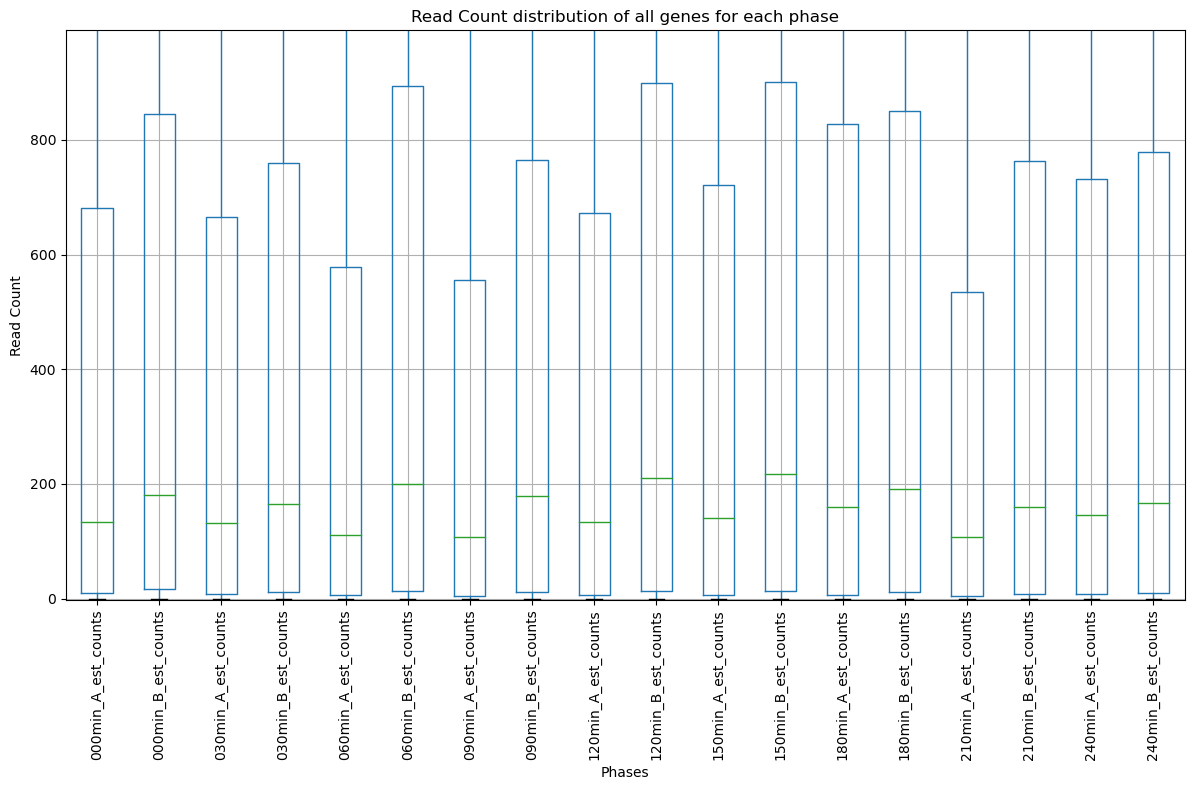

In [18]:
df_data = complete_data_df.loc[:, [col for col in complete_data_df if 'counts' in col]]

plt.figure(figsize=(12, 8))
df_data.boxplot(rot=90)
plt.title('Read Count distribution of all genes for each phase')
plt.xlabel('Phases')
plt.ylabel('Read Count')
plt.tight_layout()

max_third_quartile = np.max([np.quantile(df_data[col], 0.75) for col in list(df_data.columns)])

plt.ylim(top=max_third_quartile + max_third_quartile * 0.1)
plt.ylim(bottom=-2.5)
plt.show()

# Create a dataframe containing all TPM data at every timepoint (sorted by TTHERM_ID)

In [19]:
columns = sorted(list(dict_tpms.keys()))
columns

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [20]:
curr_df = dict_tpms['000min_A'].sort_values(by='target_id')
dict_df_all_tpm = {'TTHERM_ID': curr_df['target_id'].values}
print(curr_df.head(3))

for col in columns:
    curr_df = dict_tpms[col].sort_values(by='target_id')
    print(curr_df.head(3))
    dict_df_all_tpm[col] = (curr_df)['tpm'].values

df_all_tpm = pd.DataFrame(dict_df_all_tpm)

print(df_all_tpm.shape)

df_all_tpm.head()

            target_id  length  eff_length  est_counts       tpm       rpk  \
9250  TTHERM_00000010    1587     1398.38       347.0  2.392750  0.248144   
9249  TTHERM_00000020    1665     1476.38        10.0  0.065312  0.006773   
9248  TTHERM_00000030    1887     1698.38        54.0  0.306585  0.031795   

      tpm_manual  cpm_manual  
9250    2.392743    6.176870  
9249    0.065312    0.178008  
9248    0.306585    0.961242  
            target_id  length  eff_length  est_counts       tpm       rpk  \
9250  TTHERM_00000010    1587     1398.38       347.0  2.392750  0.248144   
9249  TTHERM_00000020    1665     1476.38        10.0  0.065312  0.006773   
9248  TTHERM_00000030    1887     1698.38        54.0  0.306585  0.031795   

      tpm_manual  cpm_manual  
9250    2.392743    6.176870  
9249    0.065312    0.178008  
9248    0.306585    0.961242  
            target_id  length  eff_length  est_counts       tpm       rpk  \
9250  TTHERM_00000010    1587     1400.31       118.0  0.

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,TTHERM_00000010,2.392750,0.710646,2.936400,1.481740,0.552868,0.531153,0.187647,0.396045,0.230034,0.328534,0.314569,0.348150,0.453546,0.433522,0.365727,0.498008,0.480000,0.551144
1,TTHERM_00000020,0.065312,0.017114,0.105053,0.025751,0.065452,0.068116,0.092421,0.006149,0.126519,0.045266,0.111743,0.029981,0.031124,0.068427,0.090699,0.052395,0.250010,0.078907
2,TTHERM_00000030,0.306585,0.029759,0.021479,0.000000,0.000000,0.009106,0.024720,0.026718,0.012222,0.014759,0.019432,0.010427,0.010818,0.027029,0.028651,0.005689,0.024687,0.010551
3,TTHERM_00000031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,TTHERM_00000040,2.242310,2.534870,1.450830,1.602540,1.701660,1.871890,1.807760,2.014030,2.020740,2.218700,2.186280,2.399470,1.938510,2.398120,1.824270,1.925910,1.772570,2.160600


In [21]:
all_cols = list(df_all_tpm.columns)
all_cols

['TTHERM_ID',
 '000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [22]:
tpm_cols = [col for col in df_all_tpm.columns[1:]]
tpm_cols

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

# Create a dataframe containing all CPM data at every timepoint (sorted by TTHERM_ID)

In [23]:
columns = sorted(list(dict_tpms.keys()))
columns

['000min_A',
 '000min_B',
 '030min_A',
 '030min_B',
 '060min_A',
 '060min_B',
 '090min_A',
 '090min_B',
 '120min_A',
 '120min_B',
 '150min_A',
 '150min_B',
 '180min_A',
 '180min_B',
 '210min_A',
 '210min_B',
 '240min_A',
 '240min_B']

In [24]:
curr_df = dict_cpms['000min_A'].sort_values(by='target_id')
dict_df_all_cpm = {'TTHERM_ID': curr_df['target_id'].values}
print(curr_df.head(3))

for col in columns:
    curr_df = dict_cpms[col].sort_values(by='target_id')
    print(curr_df.head(3))
    dict_df_all_cpm[col] = (curr_df)['cpm_manual'].values

df_all_cpm = pd.DataFrame(dict_df_all_cpm)

print(df_all_cpm.shape)

df_all_cpm.head()

            target_id  length  eff_length  est_counts       tpm       rpk  \
9250  TTHERM_00000010    1587     1398.38       347.0  2.392750  0.248144   
9249  TTHERM_00000020    1665     1476.38        10.0  0.065312  0.006773   
9248  TTHERM_00000030    1887     1698.38        54.0  0.306585  0.031795   

      tpm_manual  cpm_manual  
9250    2.392743    6.176870  
9249    0.065312    0.178008  
9248    0.306585    0.961242  
            target_id  length  eff_length  est_counts       tpm       rpk  \
9250  TTHERM_00000010    1587     1398.38       347.0  2.392750  0.248144   
9249  TTHERM_00000020    1665     1476.38        10.0  0.065312  0.006773   
9248  TTHERM_00000030    1887     1698.38        54.0  0.306585  0.031795   

      tpm_manual  cpm_manual  
9250    2.392743    6.176870  
9249    0.065312    0.178008  
9248    0.306585    0.961242  
            target_id  length  eff_length  est_counts       tpm       rpk  \
9250  TTHERM_00000010    1587     1400.31       118.0  0.

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,TTHERM_00000010,6.176870,2.213916,7.857422,4.485889,1.510879,1.661307,0.520730,1.236706,0.624212,1.006802,0.810371,1.103402,1.165294,1.231530,0.941152,1.325002,1.299130,1.502907
1,TTHERM_00000020,0.178008,0.056286,0.296836,0.082310,0.188860,0.224969,0.270779,0.020274,0.362446,0.146444,0.303889,0.100309,0.084442,0.205255,0.246492,0.147222,0.714522,0.227184
2,TTHERM_00000030,0.961242,0.112572,0.069844,0.000000,0.000000,0.034611,0.083317,0.101369,0.040272,0.054916,0.060778,0.040124,0.033777,0.093298,0.089633,0.018403,0.081196,0.034951
3,TTHERM_00000031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018305,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,TTHERM_00000040,11.463702,15.628746,7.700274,9.609679,9.216359,11.611846,9.935524,12.468427,10.853234,13.454530,11.142597,15.046394,9.879665,13.509511,9.321882,10.176749,9.516130,11.673741


# Jaccard filtering: https://academic.oup.com/bioinformatics/article/29/17/2146/240530#SEC2.2

In [25]:
from functools import reduce

def jaccard_similarity(*sets):
    if not sets:
        return 0
    # Calculate the intersection of all sets
    intersection = reduce(set.intersection, sets)
    # Calculate the union of all sets
    union = reduce(set.union, sets)
    # Compute the Jaccard similarity
    return len(intersection) / len(union)

In [26]:
np.percentile(df_all_cpm.loc[:, tpm_cols].to_numpy().flatten(), 10)

0.0

In [27]:
percentiles = np.arange(0, 30.1, 0.1)

tpm_cutoffs = []

jaccard_similarity_means = []

for _percentile in percentiles:

    tpm_cutoff = np.percentile(df_all_cpm.loc[:, tpm_cols].to_numpy().flatten(), _percentile)

    tpm_cutoffs.append(tpm_cutoff)

    jaccard_similarities = []

    df_num_cols = list(df_all_cpm.columns)[1: ]

    col_splits = [col.split('_') for col in df_num_cols]

    all_col_prefixes = ['_'.join(col_split[:len(col_split)-1]) for col_split in col_splits]

    indexes = np.unique(all_col_prefixes, return_index=True)[1]

    col_prefixes = [all_col_prefixes[index] for index in sorted(indexes)]

    for col_prefix in col_prefixes:
        cols = [col for col in df_num_cols if col.startswith(col_prefix)]

        jaccard_similarities.append(jaccard_similarity(
            *[set(df_all_cpm.loc[df_all_cpm[col] > tpm_cutoff, 'TTHERM_ID'].values) for col in cols]
        ))
        
    jaccard_similarity_means.append(np.mean(jaccard_similarities))


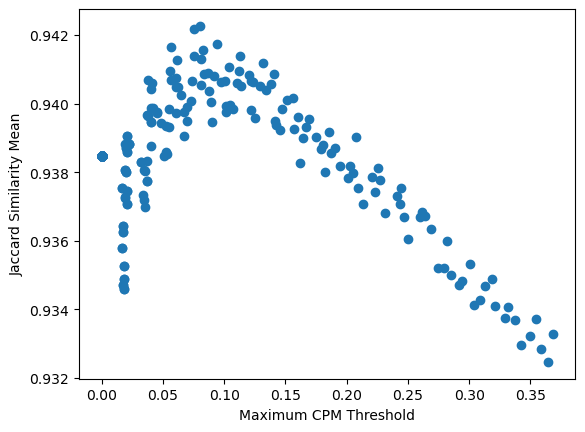

In [28]:
plt.scatter(x=tpm_cutoffs, y=jaccard_similarity_means)
plt.xlabel('Maximum CPM Threshold')
plt.ylabel('Jaccard Similarity Mean')
plt.show()

In [29]:
print(np.argmax(jaccard_similarity_means))
print(jaccard_similarity_means[np.argmax(jaccard_similarity_means)])
print(tpm_cutoffs[np.argmax(jaccard_similarity_means)])

208
0.9422657533671335
0.08024743659621893


In [30]:
CPM_THRESHOLD = tpm_cutoffs[np.argmax(jaccard_similarity_means)]

In [31]:
df_all_cpm['max_cpm'] = df_all_cpm[tpm_cols].apply(lambda x: max(x), axis=1)

In [32]:
df_all_cpm_filtered = df_all_cpm.loc[df_all_cpm['max_cpm'] > CPM_THRESHOLD]
df_all_cpm_filtered.shape, df_all_cpm.shape

((23113, 20), (26687, 20))

In [33]:
df_all_tpm.sample(10)

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
17925,TTHERM_00691740,8.874100,12.632200,9.947380,10.879400,7.565090,13.995800,6.496390,14.736900,7.744930,16.581300,6.737080,21.602200,7.126220,16.998200,8.914040,8.776240,10.377400,11.776300
17511,TTHERM_00676912,0.028859,0.134353,0.018229,0.037933,0.000000,0.023183,0.000000,0.018131,0.000000,0.049967,0.010962,0.052945,0.018364,0.073386,0.036521,0.038685,0.041905,0.008944
6630,TTHERM_00259630,51.421100,121.187000,38.004300,65.506100,28.324500,112.963000,58.036400,136.732000,104.631000,284.133000,151.769000,427.274000,173.613000,358.038000,191.966000,207.330000,256.112000,259.637000
2931,TTHERM_00122260,12.884400,6.796430,17.026300,7.154080,8.590570,4.648500,6.138460,4.292840,6.135490,3.834980,6.940520,4.337600,6.497100,5.401490,5.782850,5.988450,6.055910,4.883380
8956,TTHERM_00343740,0.197374,0.411468,0.228702,0.378365,0.153990,0.264408,0.143237,0.320466,0.188670,0.170813,0.112414,0.231257,0.167564,0.146465,0.180585,0.220730,0.172065,0.244725
15586,TTHERM_00593744,0.091815,0.089132,0.091639,0.125689,0.107314,0.081794,0.027761,0.062401,0.016472,0.053047,0.052385,0.074957,0.048582,0.043700,0.038595,0.051089,0.066521,0.037916
11698,TTHERM_00449240,5.680730,2.434980,0.790508,1.479610,0.780627,2.207220,1.101240,2.431620,0.968332,2.414750,1.278930,2.273120,1.911310,1.994140,2.676150,2.338830,2.112880,2.894690
15357,TTHERM_00584920,0.030593,0.040012,0.000000,0.060334,0.000000,0.024635,0.016652,0.043322,0.032876,0.039673,0.034801,0.042029,0.029279,0.043854,0.038884,0.046356,0.026722,0.014233
22000,TTHERM_00940270,0.050998,0.026707,0.019333,0.040222,0.000000,0.024587,0.000000,0.028841,0.032910,0.017657,0.000000,0.046773,0.000000,0.038914,0.012914,0.020519,0.008889,0.018968
8518,TTHERM_00324444,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005766,0.004641,0.000000,0.007212,0.000000,0.000000,0.004393,0.000000


## Check out genes with all zeros

In [34]:
rows_with_all_zeros = df_all_tpm[(df_all_tpm.iloc[:, 1:] == 0.0).all(axis=1)]

print(rows_with_all_zeros.shape)

rows_with_all_zeros.head()

(1160, 19)


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
41,TTHERM_00001455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112,TTHERM_00006300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119,TTHERM_00006354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173,TTHERM_00009840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236,TTHERM_00011510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Check out rows with one nonzero

In [35]:
rows_with_one_nonzero = df_all_tpm[(df_all_tpm.iloc[:, 1:] == 0.0).sum(axis=1) == 17]

print(rows_with_one_nonzero.shape)

rows_with_one_nonzero.head()

(472, 19)


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
3,TTHERM_00000031,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.04663,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
135,TTHERM_00007490,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.049759,0.0
332,TTHERM_00013560,0.428543,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
442,TTHERM_00019600,0.000000,0.0,0.006222,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0
584,TTHERM_00029970,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.031964,0.0,0.0,0.0,0.0,0.000000,0.0


## Check out the distribution of the number of zeros

In [36]:
num_zeros_counts = {}

for i in range(20):
    num_zeros = (df_all_tpm.iloc[:, 1:] == 0.0).sum(axis=1)
    
    rows_with_num_zeros = df_all_tpm[num_zeros == i]
    
    num_zeros_counts[i] = len(rows_with_num_zeros)

for num_zeros, count in num_zeros_counts.items():
    print(f"Number of rows with {num_zeros} zeros: {count}")

Number of rows with 0 zeros: 20958
Number of rows with 1 zeros: 583
Number of rows with 2 zeros: 349
Number of rows with 3 zeros: 345
Number of rows with 4 zeros: 234
Number of rows with 5 zeros: 236
Number of rows with 6 zeros: 228
Number of rows with 7 zeros: 211
Number of rows with 8 zeros: 186
Number of rows with 9 zeros: 183
Number of rows with 10 zeros: 195
Number of rows with 11 zeros: 177
Number of rows with 12 zeros: 196
Number of rows with 13 zeros: 204
Number of rows with 14 zeros: 204
Number of rows with 15 zeros: 262
Number of rows with 16 zeros: 304
Number of rows with 17 zeros: 472
Number of rows with 18 zeros: 1160
Number of rows with 19 zeros: 0


## Filter out genes with all zeros

In [37]:
df_no_all_zeros = df_all_tpm[~df_all_tpm.isin(rows_with_all_zeros)].dropna()
df_no_all_zeros.reset_index()
print(df_all_tpm.shape[0]-df_no_all_zeros.shape[0])
df_no_all_zeros.head()

1160


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,TTHERM_00000010,2.392750,0.710646,2.936400,1.481740,0.552868,0.531153,0.187647,0.396045,0.230034,0.328534,0.314569,0.348150,0.453546,0.433522,0.365727,0.498008,0.480000,0.551144
1,TTHERM_00000020,0.065312,0.017114,0.105053,0.025751,0.065452,0.068116,0.092421,0.006149,0.126519,0.045266,0.111743,0.029981,0.031124,0.068427,0.090699,0.052395,0.250010,0.078907
2,TTHERM_00000030,0.306585,0.029759,0.021479,0.000000,0.000000,0.009106,0.024720,0.026718,0.012222,0.014759,0.019432,0.010427,0.010818,0.027029,0.028651,0.005689,0.024687,0.010551
3,TTHERM_00000031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.046630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,TTHERM_00000040,2.242310,2.534870,1.450830,1.602540,1.701660,1.871890,1.807760,2.014030,2.020740,2.218700,2.186280,2.399470,1.938510,2.398120,1.824270,1.925910,1.772570,2.160600


In [38]:
df_all_zeros = df_all_tpm[df_all_tpm.isin(rows_with_all_zeros)].dropna()
df_all_zeros.reset_index()
print(df_all_tpm.shape[0]-df_all_zeros.shape[0])
df_all_zeros.head()

25527


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
41,TTHERM_00001455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112,TTHERM_00006300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119,TTHERM_00006354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173,TTHERM_00009840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
236,TTHERM_00011510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
df_no_all_zeros.shape

(25527, 19)

## Check out the genes which display the highest expression

In [40]:
[np.max(df_no_all_zeros[col]) for col in list(df_no_all_zeros.columns)[1:]]

[28942.1,
 40870.4,
 31016.2,
 45994.6,
 31964.5,
 44656.7,
 31242.3,
 39961.5,
 30575.7,
 41728.1,
 31284.7,
 46152.2,
 33897.7,
 32471.1,
 30873.1,
 31104.1,
 32780.3,
 31424.2]

In [41]:
max_tpm_ttherms = []

for col in df_no_all_zeros.columns[1:]:
    max_tpm = df_no_all_zeros[col].max()
    max_tpm_ttherm = df_no_all_zeros['TTHERM_ID'].loc[df_no_all_zeros[col] == df_no_all_zeros[col].max()].values[0]
    print(col, 'MAX:', max_tpm, '|', max_tpm_ttherm)
    max_tpm_ttherms.append(max_tpm_ttherm)
    

000min_A MAX: 28942.1 | TTHERM_01068180
000min_B MAX: 40870.4 | TTHERM_00526400
030min_A MAX: 31016.2 | TTHERM_01068180
030min_B MAX: 45994.6 | TTHERM_00760295
060min_A MAX: 31964.5 | TTHERM_01068180
060min_B MAX: 44656.7 | TTHERM_00760295
090min_A MAX: 31242.3 | TTHERM_01068180
090min_B MAX: 39961.5 | TTHERM_00526400
120min_A MAX: 30575.7 | TTHERM_01068180
120min_B MAX: 41728.1 | TTHERM_00526400
150min_A MAX: 31284.7 | TTHERM_01068180
150min_B MAX: 46152.2 | TTHERM_00526400
180min_A MAX: 33897.7 | TTHERM_01068180
180min_B MAX: 32471.1 | TTHERM_00526400
210min_A MAX: 30873.1 | TTHERM_01068180
210min_B MAX: 31104.1 | TTHERM_01068180
240min_A MAX: 32780.3 | TTHERM_01068180
240min_B MAX: 31424.2 | TTHERM_01068180


In [42]:
np.unique(max_tpm_ttherms)

array(['TTHERM_00526400', 'TTHERM_00760295', 'TTHERM_01068180'],
      dtype='<U15')

# FILTER OUT GENES IN THE TPM DATAFRAME

In [43]:
df_filtered = df_all_tpm.loc[df_all_tpm['TTHERM_ID'].isin(df_all_cpm_filtered['TTHERM_ID'].values)]

In [44]:
df_filtered.shape, df_no_all_zeros.shape, df_all_tpm.shape

((23113, 19), (25527, 19), (26687, 19))

In [45]:
df_filtered.loc[df_filtered['TTHERM_ID'].isin(df_all_zeros['TTHERM_ID'].values)]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B


In [46]:
df_filtered.head()

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,TTHERM_00000010,2.392750,0.710646,2.936400,1.481740,0.552868,0.531153,0.187647,0.396045,0.230034,0.328534,0.314569,0.348150,0.453546,0.433522,0.365727,0.498008,0.480000,0.551144
1,TTHERM_00000020,0.065312,0.017114,0.105053,0.025751,0.065452,0.068116,0.092421,0.006149,0.126519,0.045266,0.111743,0.029981,0.031124,0.068427,0.090699,0.052395,0.250010,0.078907
2,TTHERM_00000030,0.306585,0.029759,0.021479,0.000000,0.000000,0.009106,0.024720,0.026718,0.012222,0.014759,0.019432,0.010427,0.010818,0.027029,0.028651,0.005689,0.024687,0.010551
4,TTHERM_00000040,2.242310,2.534870,1.450830,1.602540,1.701660,1.871890,1.807760,2.014030,2.020740,2.218700,2.186280,2.399470,1.938510,2.398120,1.824270,1.925910,1.772570,2.160600
5,TTHERM_00000047,0.124883,0.061840,0.133771,0.143597,0.162613,0.186829,0.412327,0.489517,0.985978,0.689203,1.834060,0.703661,1.902240,1.069510,0.618985,1.033190,0.209819,0.622642


In [47]:
[np.max(df_filtered[col]) for col in tpm_cols]

[28942.1,
 40870.4,
 31016.2,
 45994.6,
 31964.5,
 44656.7,
 31242.3,
 39961.5,
 30575.7,
 41728.1,
 31284.7,
 46152.2,
 33897.7,
 32471.1,
 30873.1,
 31104.1,
 32780.3,
 31424.2]

# Filter out genes with all zeros

In [48]:
df_filtered_with_all_zeros = df_filtered[(df_filtered.iloc[:, 1:] == 0.0).all(axis=1)]

print(df_filtered_with_all_zeros.shape)

df_filtered_with_all_zeros.head()

(0, 19)


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B


In [49]:
df_filtered_no_all_zeros = df_filtered[~df_filtered.isin(df_filtered_with_all_zeros)].dropna()
df_filtered_no_all_zeros.reset_index()
print(df_filtered.shape[0])
print(df_filtered_no_all_zeros.shape[0])
print(df_filtered.shape[0]-df_filtered_no_all_zeros.shape[0])
df_filtered_no_all_zeros.head()

23113
23113
0


,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,TTHERM_00000010,2.392750,0.710646,2.936400,1.481740,0.552868,0.531153,0.187647,0.396045,0.230034,0.328534,0.314569,0.348150,0.453546,0.433522,0.365727,0.498008,0.480000,0.551144
1,TTHERM_00000020,0.065312,0.017114,0.105053,0.025751,0.065452,0.068116,0.092421,0.006149,0.126519,0.045266,0.111743,0.029981,0.031124,0.068427,0.090699,0.052395,0.250010,0.078907
2,TTHERM_00000030,0.306585,0.029759,0.021479,0.000000,0.000000,0.009106,0.024720,0.026718,0.012222,0.014759,0.019432,0.010427,0.010818,0.027029,0.028651,0.005689,0.024687,0.010551
4,TTHERM_00000040,2.242310,2.534870,1.450830,1.602540,1.701660,1.871890,1.807760,2.014030,2.020740,2.218700,2.186280,2.399470,1.938510,2.398120,1.824270,1.925910,1.772570,2.160600
5,TTHERM_00000047,0.124883,0.061840,0.133771,0.143597,0.162613,0.186829,0.412327,0.489517,0.985978,0.689203,1.834060,0.703661,1.902240,1.069510,0.618985,1.033190,0.209819,0.622642


In [50]:
df_filtered_no_all_zeros

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
0,TTHERM_00000010,2.392750,0.710646,2.936400,1.481740,0.552868,0.531153,0.187647,0.396045,0.230034,0.328534,0.314569,0.348150,0.453546,0.433522,0.365727,0.498008,0.480000,0.551144
1,TTHERM_00000020,0.065312,0.017114,0.105053,0.025751,0.065452,0.068116,0.092421,0.006149,0.126519,0.045266,0.111743,0.029981,0.031124,0.068427,0.090699,0.052395,0.250010,0.078907
2,TTHERM_00000030,0.306585,0.029759,0.021479,0.000000,0.000000,0.009106,0.024720,0.026718,0.012222,0.014759,0.019432,0.010427,0.010818,0.027029,0.028651,0.005689,0.024687,0.010551
4,TTHERM_00000040,2.242310,2.534870,1.450830,1.602540,1.701660,1.871890,1.807760,2.014030,2.020740,2.218700,2.186280,2.399470,1.938510,2.398120,1.824270,1.925910,1.772570,2.160600
5,TTHERM_00000047,0.124883,0.061840,0.133771,0.143597,0.162613,0.186829,0.412327,0.489517,0.985978,0.689203,1.834060,0.703661,1.902240,1.069510,0.618985,1.033190,0.209819,0.622642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26680,TTHERM_02653503,0.980579,3.725720,1.413220,5.371690,1.881150,5.763860,2.128700,6.852220,2.505580,6.086270,1.529360,5.320890,0.955522,3.204800,0.493389,3.701870,2.277960,3.124150
26681,TTHERM_02653508,8.679450,15.797800,9.162470,14.646200,12.037900,16.883000,14.161500,17.241900,11.999300,18.251500,10.362000,17.859500,7.809500,13.069300,8.018720,9.962080,9.153860,9.997680
26683,TTHERM_02653516,1.048350,0.986232,0.594687,0.859194,0.300709,0.602789,0.237124,0.539547,0.219536,0.766409,0.309892,0.562066,0.234399,0.559173,0.432144,0.508124,0.570547,0.646110
26684,TTHERM_02653518,1.432380,1.241940,1.223780,1.402420,0.786592,0.988750,0.620208,0.935363,0.727973,0.760378,0.710016,0.769129,0.762623,0.820501,0.943048,1.074950,1.211450,1.165040


In [51]:
df_filtered_no_all_zeros[df_filtered_no_all_zeros.isna().any(axis=1)]

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B


In [52]:
df_filtered_no_all_zeros.sample(10)

,TTHERM_ID,000min_A,000min_B,030min_A,030min_B,060min_A,060min_B,090min_A,090min_B,120min_A,120min_B,150min_A,150min_B,180min_A,180min_B,210min_A,210min_B,240min_A,240min_B
9291,TTHERM_00355060,0.014945,0.026103,0.042440,0.066294,0.037451,0.059974,0.024402,0.084447,0.016081,0.051779,0.008521,0.089163,0.014250,0.071199,0.018882,0.089992,0.052031,0.069456
4735,TTHERM_00188440,6.485290,6.273820,7.423840,5.667670,4.801830,4.039220,3.435230,3.486990,3.011590,3.170170,2.892970,2.982680,3.924960,3.429190,5.108950,4.368440,5.034410,4.433250
6349,TTHERM_00245800,0.015169,0.019892,0.007161,0.020555,0.005695,0.016700,0.004128,0.021390,0.006127,0.023023,0.002166,0.010458,0.005410,0.014422,0.009541,0.005682,0.004938,0.012327
26003,TTHERM_01374860,0.026660,0.036306,0.012651,0.028878,0.000000,0.010725,0.017342,0.050305,0.000000,0.012421,0.015173,0.030287,0.025531,0.000000,0.016918,0.000000,0.000000,0.000000
22398,TTHERM_00971820,0.949224,1.381690,0.765234,0.887145,1.247340,1.100210,1.362350,1.132130,1.286280,1.175510,1.194790,1.290880,1.769580,1.801810,2.335490,1.812810,1.847790,2.025840
18582,TTHERM_00721170,8.940110,7.051400,12.256500,6.875770,8.271220,6.378850,8.263910,6.252780,7.971660,5.996450,7.860190,6.355080,7.662350,6.792020,7.814150,7.439300,8.294010,8.633600
2467,TTHERM_00095640,0.235967,0.478849,0.072245,0.177866,0.132158,0.178201,0.370170,0.176437,0.477981,0.432862,0.403668,0.477820,0.337408,0.456171,0.245406,0.341130,0.157014,0.419263
19440,TTHERM_00765260,0.188962,0.354920,0.138027,0.157659,0.102144,0.409545,0.284827,0.274380,0.296819,0.339358,0.198465,0.426095,0.180782,0.277751,0.166192,0.278805,0.215766,0.148763
11514,TTHERM_00444470,122.218000,140.248000,318.120000,291.081000,436.911000,363.972000,493.501000,378.202000,462.843000,245.112000,455.038000,212.176000,404.503000,288.654000,438.780000,356.891000,367.564000,353.920000
1590,TTHERM_00059523,0.004917,0.004299,0.001547,0.009691,0.000000,0.002624,0.000000,0.006162,0.001765,0.008529,0.009361,0.010547,0.000000,0.003116,0.004122,0.006547,0.005691,0.006088


# Export the filtered TPM data to CSV

In [53]:
df_filtered_no_all_zeros.to_csv('../../active_files/rna_seq.csv', index=False)